In [109]:
import numpy as np
import pandas as pd
from time import time
import os
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import time
import sys
import copy
from IPython.display import display_html


%matplotlib inline
plt.rcParams['figure.figsize'] = (20,15) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part A
## Q1 - 2

In [110]:
def euclidean(list_A, list_B):
    diff_vect = list_A - list_B
    return np.sqrt(np.dot(diff_vect,diff_vect))

def manhattan(list_A, list_B):
    from numpy import sqrt
    a_b = zip(list_A, list_B)
    manhattan = 0
    for x,y in a_b:
        manhattan += abs(x-y)
    return manhattan

def RangeQuery(X, distance_metric, point, eps):
    N = []
    dist = 100
    for i in (range(len(X))):
        if distance_metric is 'euclidean':
            dist = euclidean(X[i],point)
        if distance_metric is 'manhattan':
            dist = manhattan(X[i],point)
        if dist <= eps:
            N.append(i)
    return N


def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [119]:
class DBSCAN():
    def fit(self, X, eps, min_samples, distance_metric):
        C=0
        label = dict.fromkeys(range(len(X)), "unvisited")
        for i in range(len(X)):
            sys.stdout.write( '\r'+"currently looking at row "+str(i))
            if (label[i] != "unvisited"): 
                continue
            N = RangeQuery(X, distance_metric, X[i], eps)
            if (len(N)<min_samples):
                label[i] = -1
                continue
            C = C+1
            label[i]= C
            N.remove(i)
            S = list(copy.deepcopy(np.unique(N)))
            for Q in range(len(S)):
                if label[S[Q]] == -1:
                    label[S[Q]] = C
                if label[S[Q]] != "unvisited":
                    continue
                label[S[Q]] = C
                N = RangeQuery(X, distance_metric, X[Q], eps)
                if len(N) >= min_samples:
                    S.append(N)
        return list(label.values())

    def __init__(self):
            pass
            

In [120]:
# Extra Credit 

#store all distances
def Distance_matrix(X):
    euclid = np.zeros(shape=(len(X),len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            if euclid[i][j] == 0 & i!=j:
                euclid[i][j] = euclidean(X[i],X[j])
                euclid[j][i] = euclid[i][j]
    return euclid

def opt_RangeQuery( point_dist, eps ):
    N = (np.nonzero(point_dist < eps))
    N = N[0].tolist()
    return N

In [121]:
class opt_DBSCAN():
    def fit(self, X, eps, min_samples):
        C=0
        label = dict.fromkeys(range(len(X)), "unvisited")
        euclid = Distance_matrix(X)
        for i in range(len(X)):
            sys.stdout.write( '\r'+"currently looking at row "+str(i))
            if (label[i] != "unvisited"): 
                continue
            N = opt_RangeQuery(euclid[i],eps)
            if (len(N)<min_samples):
                label[i] = -1
                continue
            C = C+1
            label[i]= C
            N.remove(i)
            S = list(copy.deepcopy(np.unique(N)))
            for Q in range(len(S)):
                if label[S[Q]] == -1:
                    label[S[Q]] = C
                if label[S[Q]] != "unvisited":
                    continue
                label[S[Q]] = C
                N = opt_RangeQuery(euclid[i],eps)
                if len(N) >= min_samples:
                    S.append(N)
        return list(label.values())

    def __init__(self):
            pass
            

## Q3 - 6:


In [122]:
movies = pd.read_csv('Assignment3_Dataset/movies_metadata.csv')

#retain numeric columns for clustering
movies = movies[['budget','popularity','revenue','runtime','vote_average','vote_count']]

# drop rows with null or NaN values
movies = movies[~movies.isnull().any(axis=1)]
movies = movies.dropna()

# remove movies with less than 30 votes
movies = movies[movies['vote_count'] > 30]
movies.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,budget,popularity,revenue,runtime,vote_average,vote_count
0,30000000,21.9469,373554033.0,81.0,7.7,5415.0
1,65000000,17.0155,262797249.0,104.0,6.9,2413.0
2,0,11.7129,0.0,101.0,6.5,92.0
3,16000000,3.85949,81452156.0,127.0,6.1,34.0
4,0,8.38752,76578911.0,106.0,5.7,173.0


In [123]:
scaler = StandardScaler()
movies_standardized = scaler.fit_transform(movies.values)

## Q7 - 10

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [35]:
sum_of_squared_distances = []
k_range = range(1,15)
for k in k_range:
    km = KMeans(n_clusters=k)
    km = km.fit(movies_standardized)
    sum_of_squared_distances.append(km.inertia_)

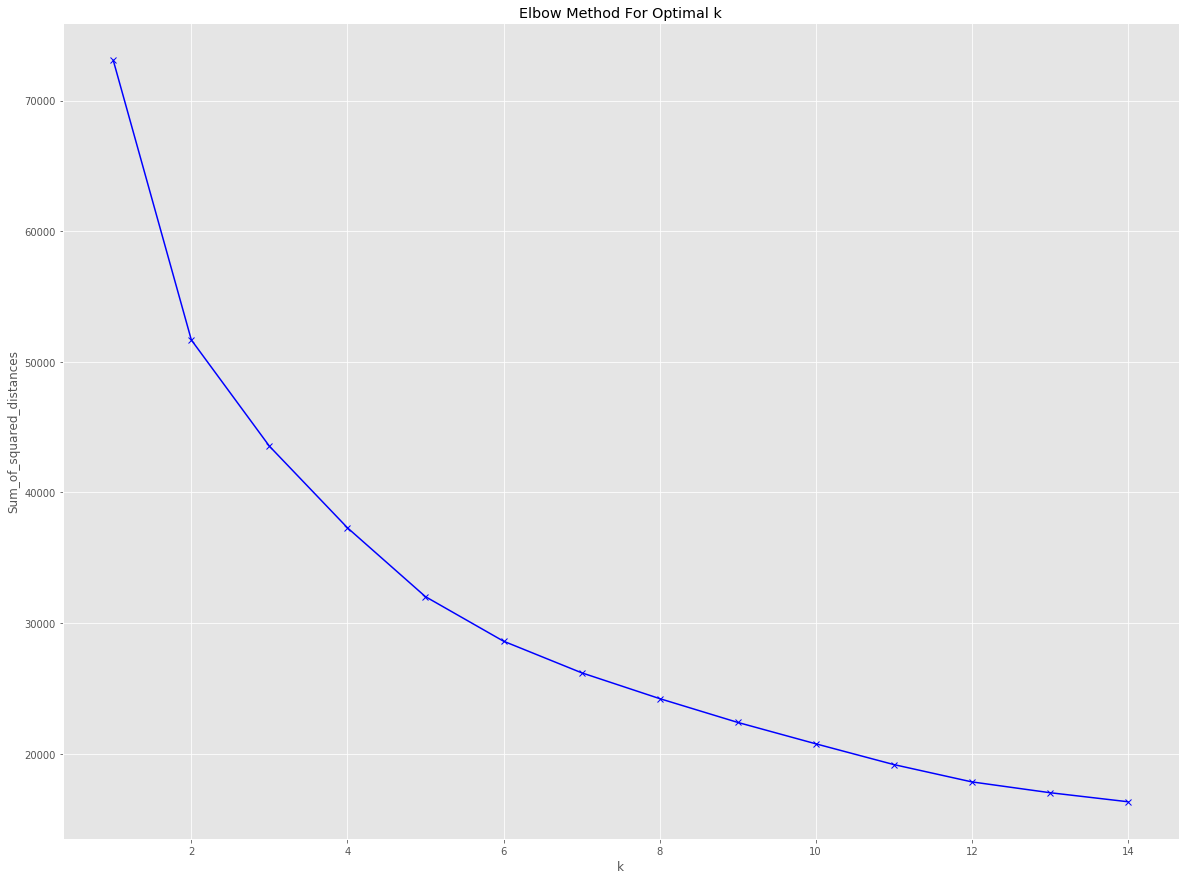

In [36]:
plt.plot(k_range, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [37]:
silhouette_scores = []
k_range = range(2,11)
for k in k_range:
    km = KMeans(n_clusters=k)
    km_labels = km.fit_predict(movies_standardized)
    silhouette_avg = silhouette_score(movies_standardized[:,0:2:2],km_labels,metric='l1')
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_scores.append(silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.7884408928459605
For n_clusters = 3 The average silhouette_score is : 0.02472251578762818
For n_clusters = 4 The average silhouette_score is : 0.019021051326866375
For n_clusters = 5 The average silhouette_score is : 0.035210211291372244
For n_clusters = 6 The average silhouette_score is : 0.04290299719460986
For n_clusters = 7 The average silhouette_score is : -0.06505768869045643
For n_clusters = 8 The average silhouette_score is : -0.0241759324516436
For n_clusters = 9 The average silhouette_score is : -0.24853183120635028
For n_clusters = 10 The average silhouette_score is : -0.4814214609149157


#### Metrics tried
* euclidean -> optimal is 2 with silhouette score = 0.687
* l1 -> optimal is 2 with silhouette score = 0.715
* l2 -> optimal is 2 with silhouette score = 0.687
* manhattan -> optimal is 2 with silhouette score = 0.715
##### for fun, also tried:
* cityblock -> optimal is 2 with silhouette score = 0.715
* cosine -> optimal is 3 with silhouette score = 0.353

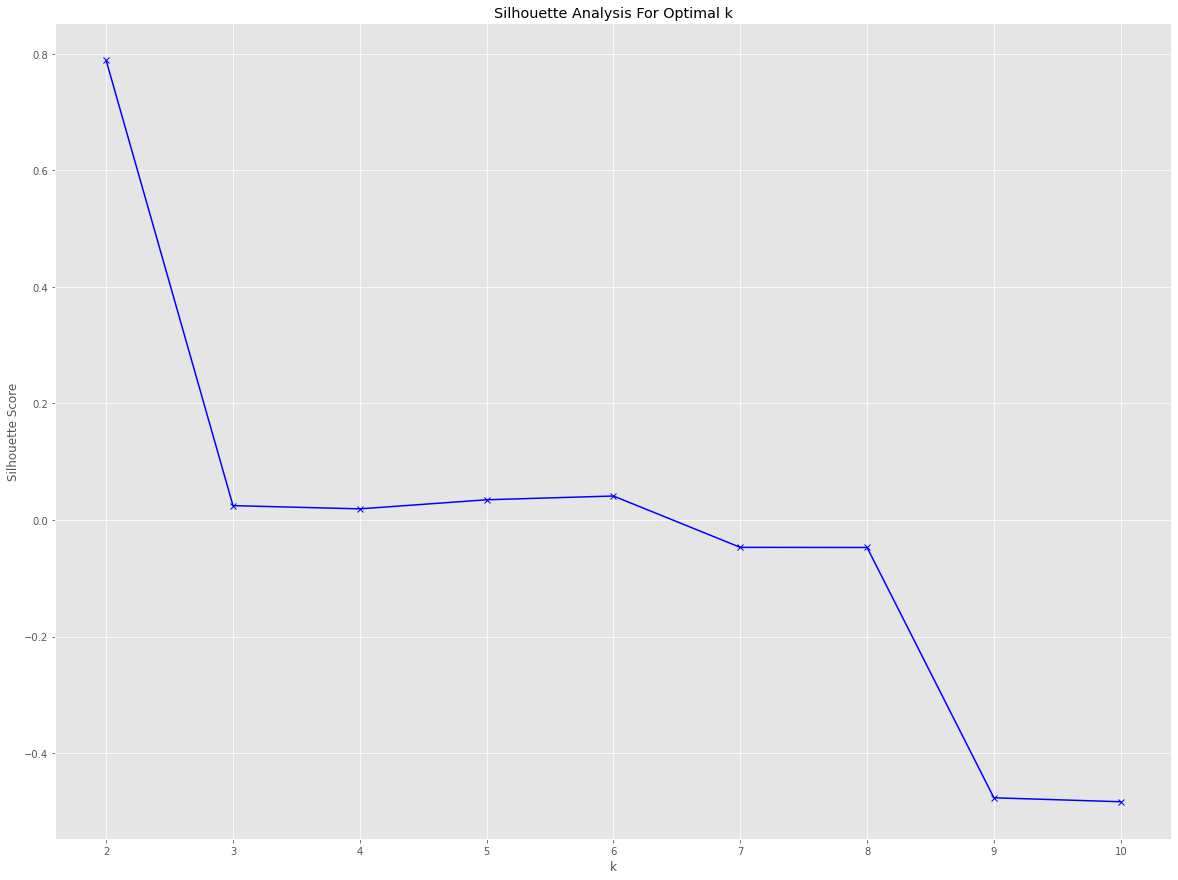

In [20]:
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

In [21]:
## Part B-Q8: Perform clustering on KMeans model
opt_kmeans = KMeans(n_clusters=2)
opt_kmeans = opt_kmeans.fit(movies_standardized)

In [22]:
## Part B-Q9: Which distance metric did you use & why
## Used 'l1' because it gave the highest silhouette score. All metrics gave similar silhouette scores and 
## this made us confident in selecting n_clusters = 2. The inertia_ metric also agreed with using n_clusters=2.

In [ ]:
## Part B-Q10: Interpret the clusters based on the features used for clustering.
##  How is cluster size related to the features (revenue, vote_count, etc.)?
## ANSWERED IN THE REPORT
## figures for answer are below

In [23]:
pred_cluster = opt_kmeans.predict(movies_standardized)

Text(0, 0.5, 'Budget (in millions $)')

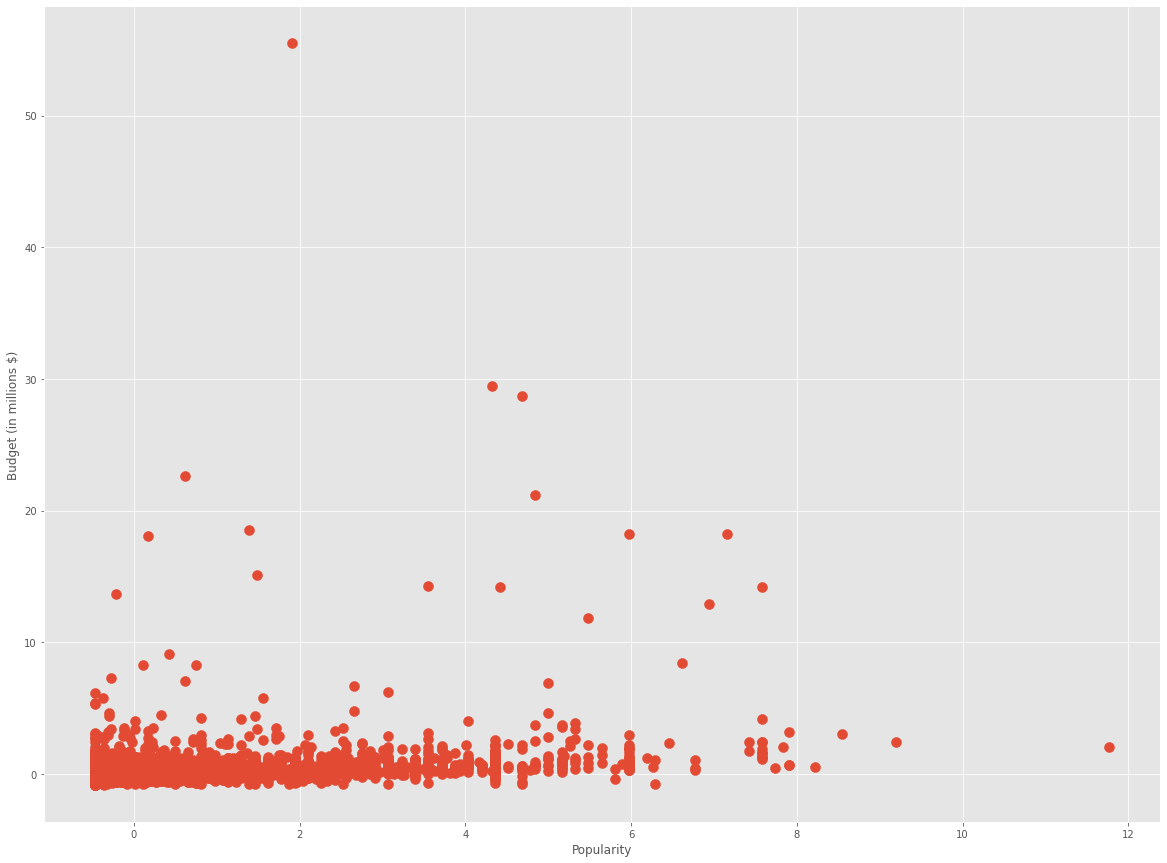

In [24]:
plt.scatter(movies_standardized[:,0],movies_standardized[:,1],s=100)
plt.xlabel('Popularity')
plt.ylabel('Budget (in millions $)')

Text(0, 0.5, 'Budget (in millions $)')

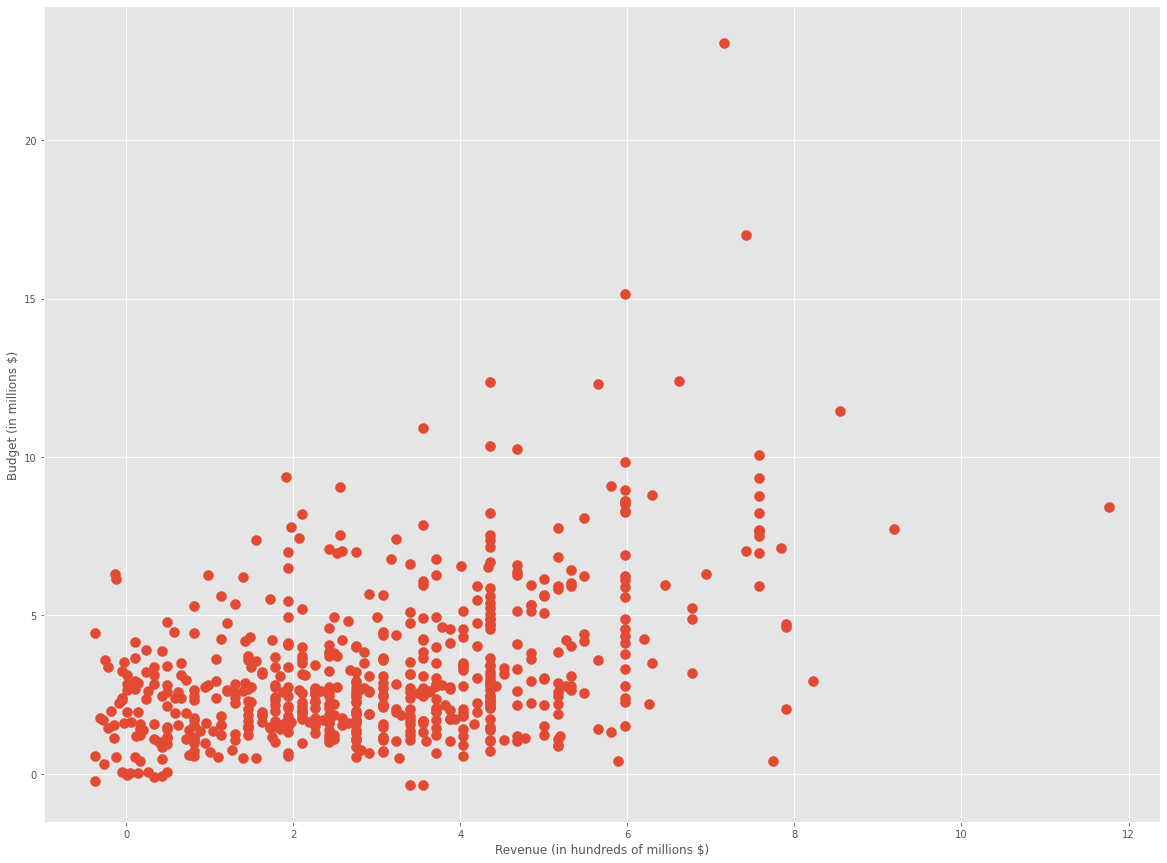

In [25]:
plt.scatter(movies_standardized[:,0][pred_cluster==1],movies_standardized[:,2][pred_cluster==1],s=100)
plt.xlabel('Revenue (in hundreds of millions $)')
plt.ylabel('Budget (in millions $)')

Text(0, 0.5, 'Budget (in millions $)')

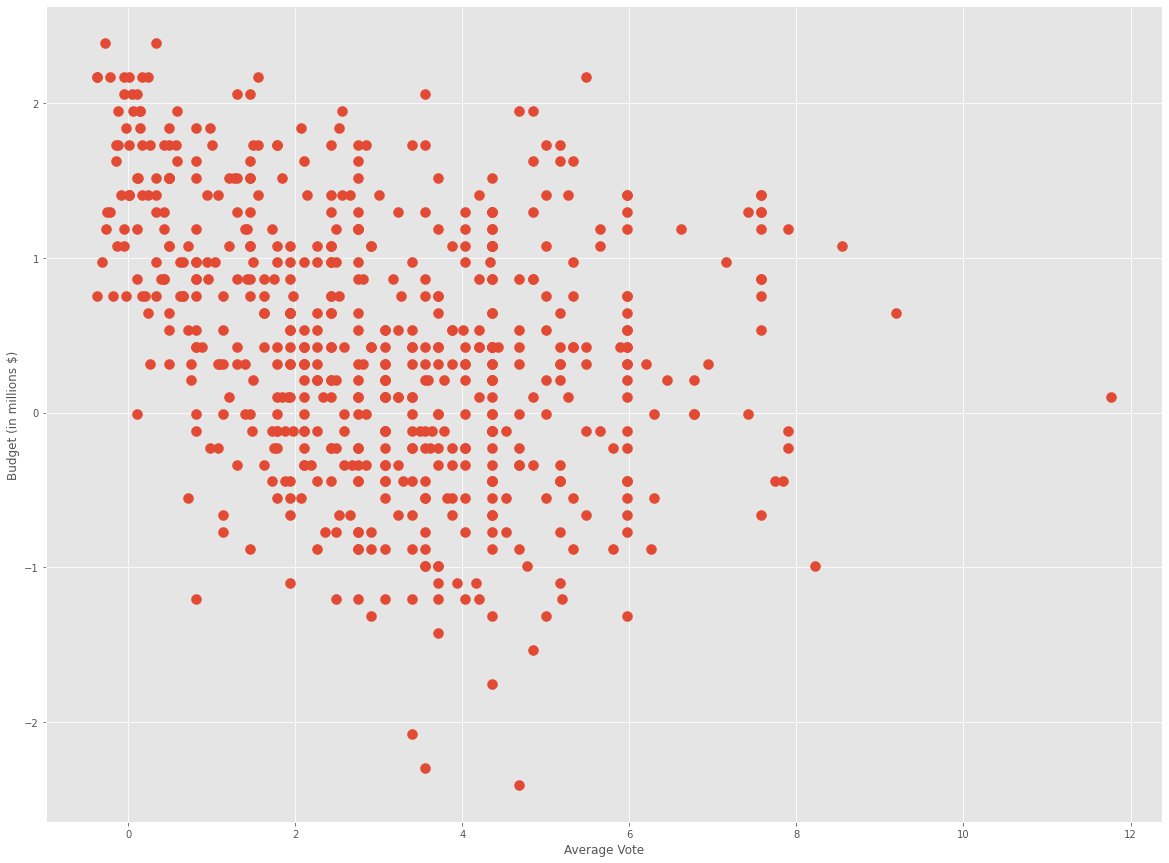

In [26]:
plt.scatter(movies_standardized[:,0][pred_cluster==1],movies_standardized[:,4][pred_cluster==1],s=100)
plt.xlabel('Average Vote')
plt.ylabel('Budget (in millions $)')

Text(0, 0.5, 'Budget (in millions $)')

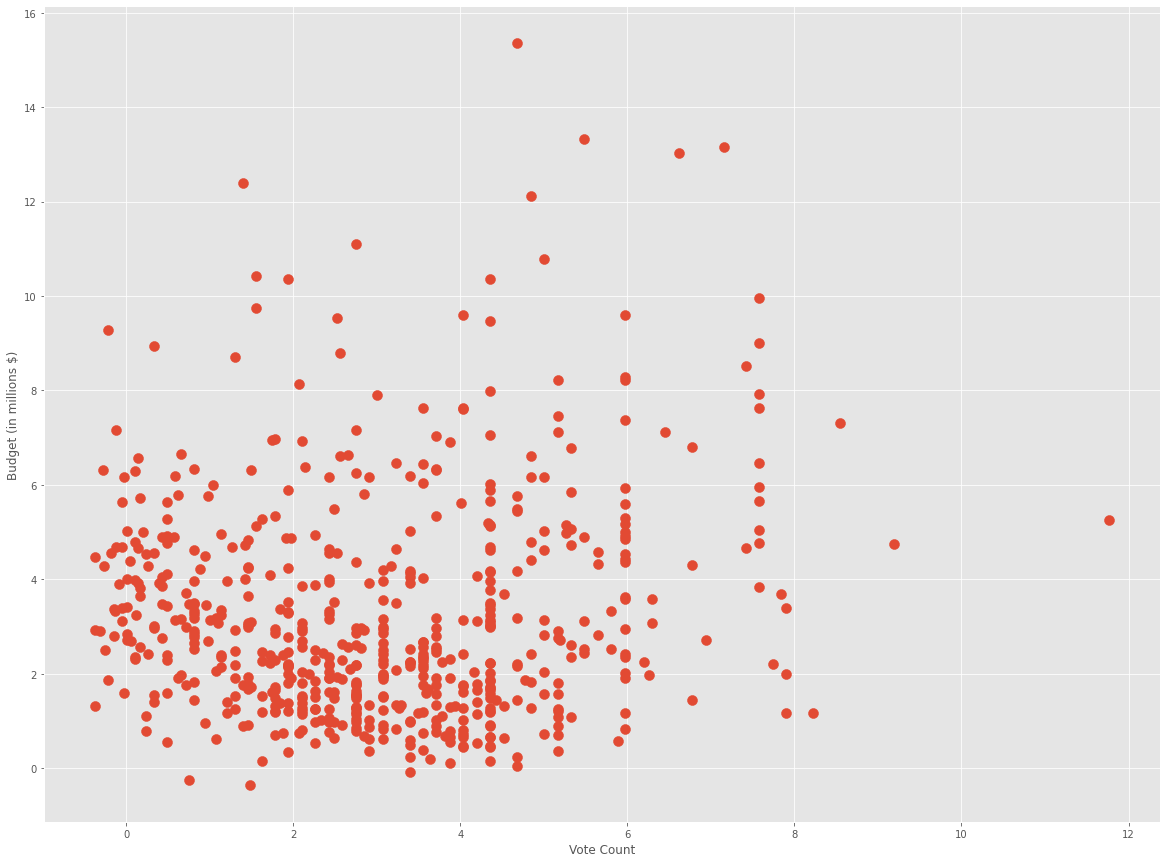

In [27]:
plt.scatter(movies_standardized[:,0][pred_cluster==1],movies_standardized[:,5][pred_cluster==1],s=100)
plt.xlabel('Vote Count')
plt.ylabel('Budget (in millions $)')

Text(0, 0.5, 'Budget (in millions $)')

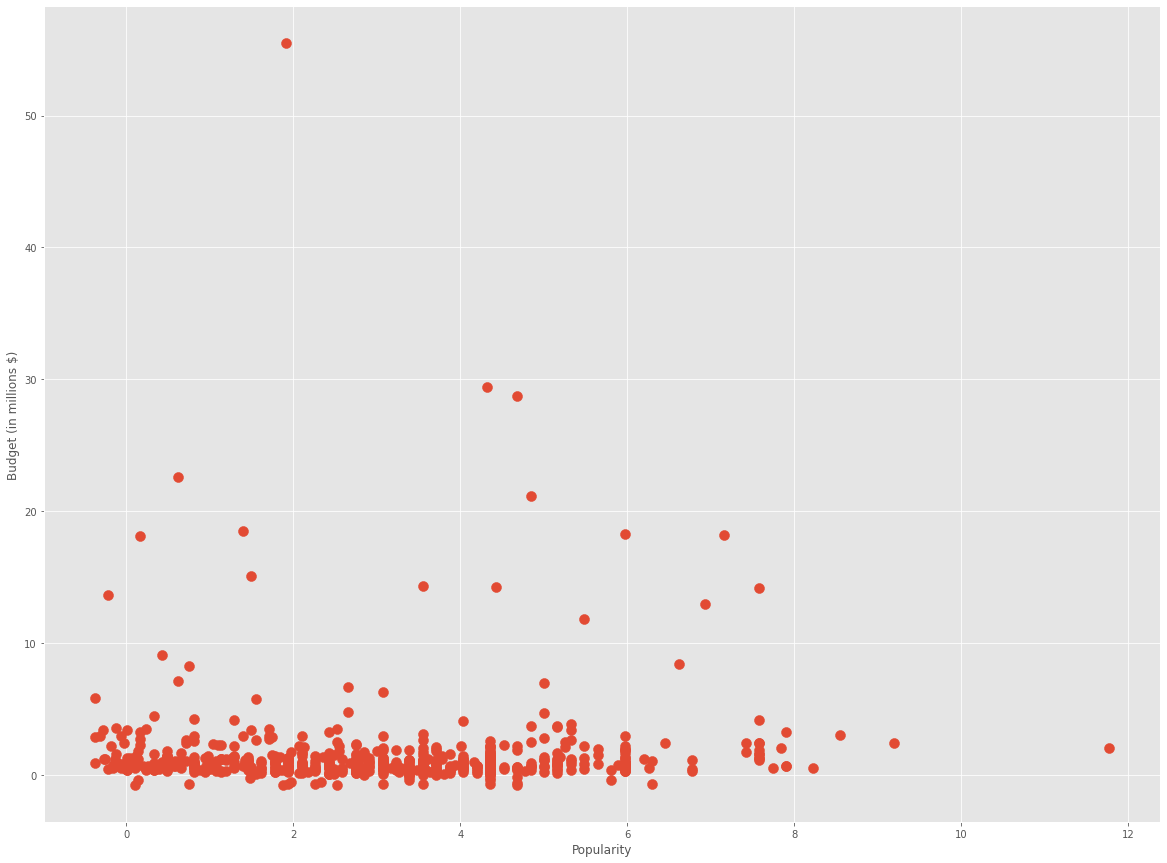

In [28]:
plt.scatter(movies_standardized[:,0][pred_cluster==1],movies_standardized[:,1][pred_cluster==1],s=100)
plt.xlabel('Popularity')
plt.ylabel('Budget (in millions $)')

Text(0, 0.5, 'Vote Count')

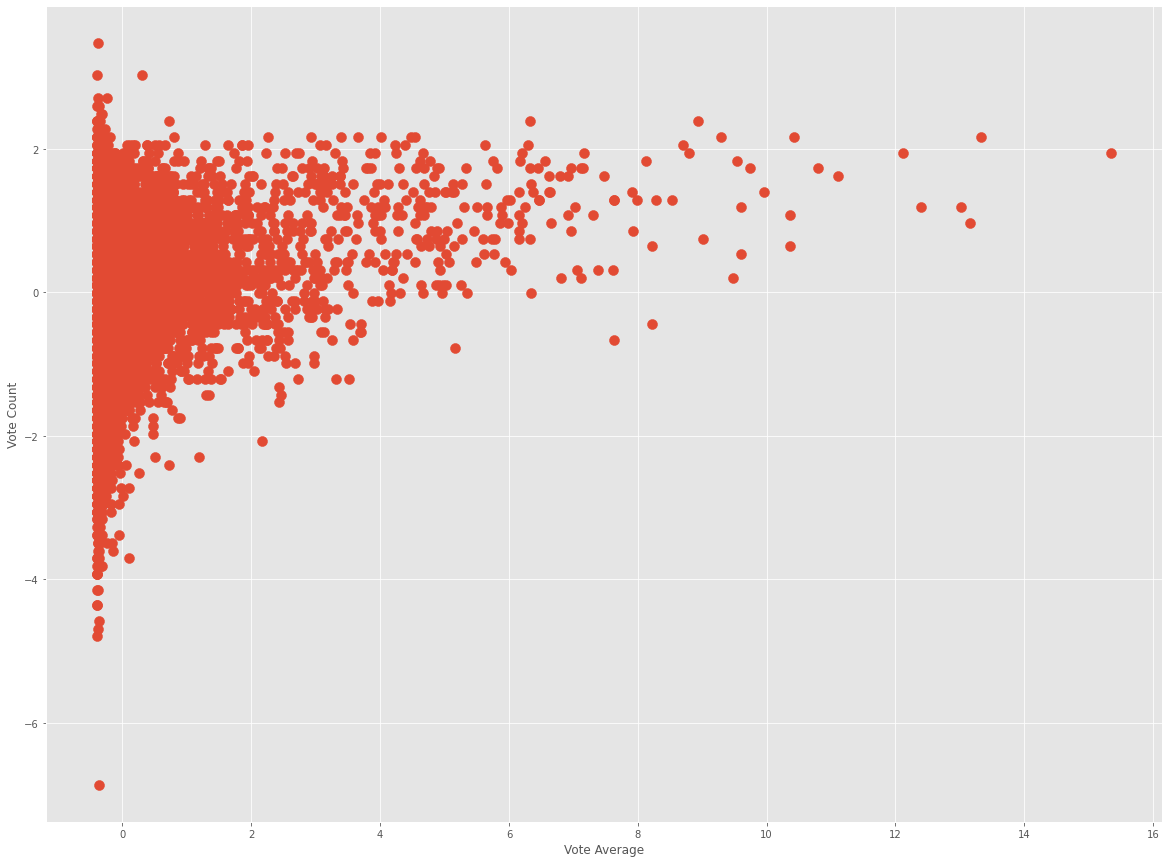

In [29]:
plt.scatter(movies_standardized[:,5],movies_standardized[:,4],s=100)
plt.xlabel('Vote Average')
plt.ylabel('Vote Count')

Text(0, 0.5, 'Revenue')

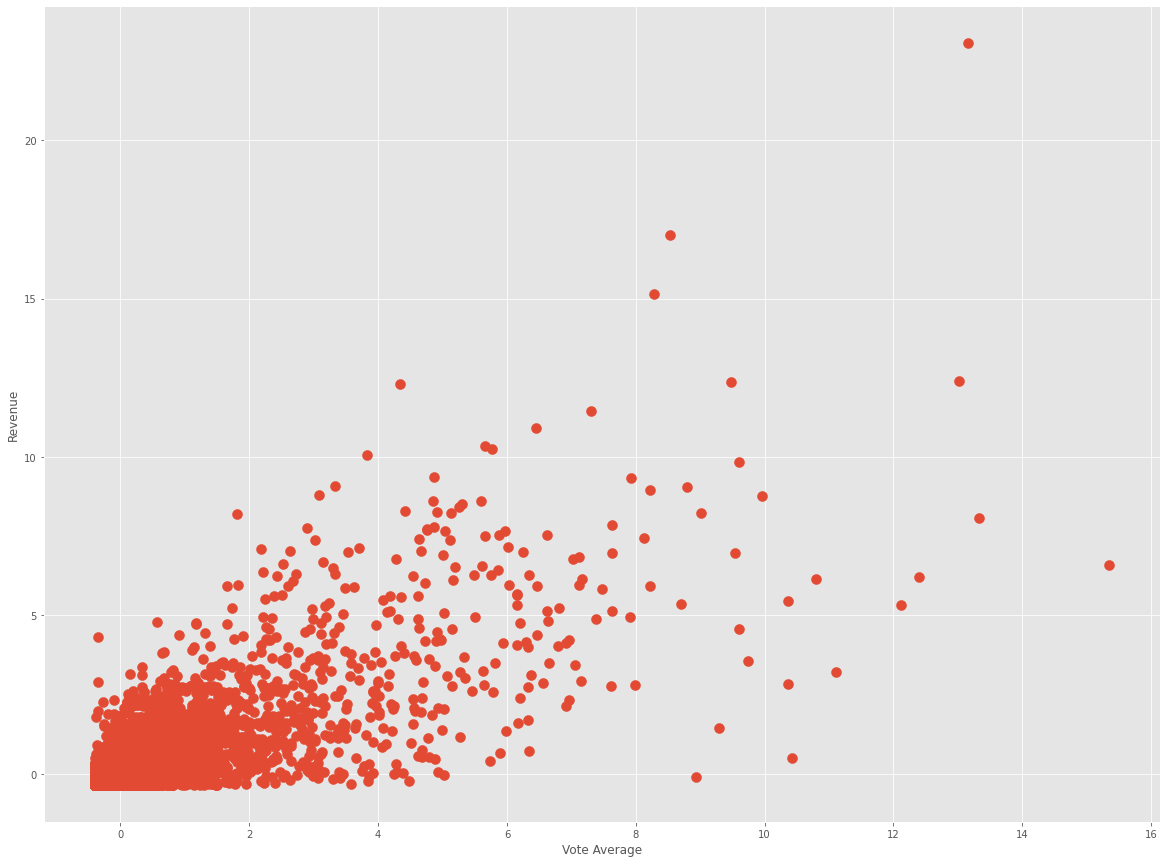

In [30]:
plt.scatter(movies_standardized[:,5],movies_standardized[:,2],s=100)
plt.xlabel('Vote Average')
plt.ylabel('Revenue')

Text(0, 0.5, 'Vote Count')

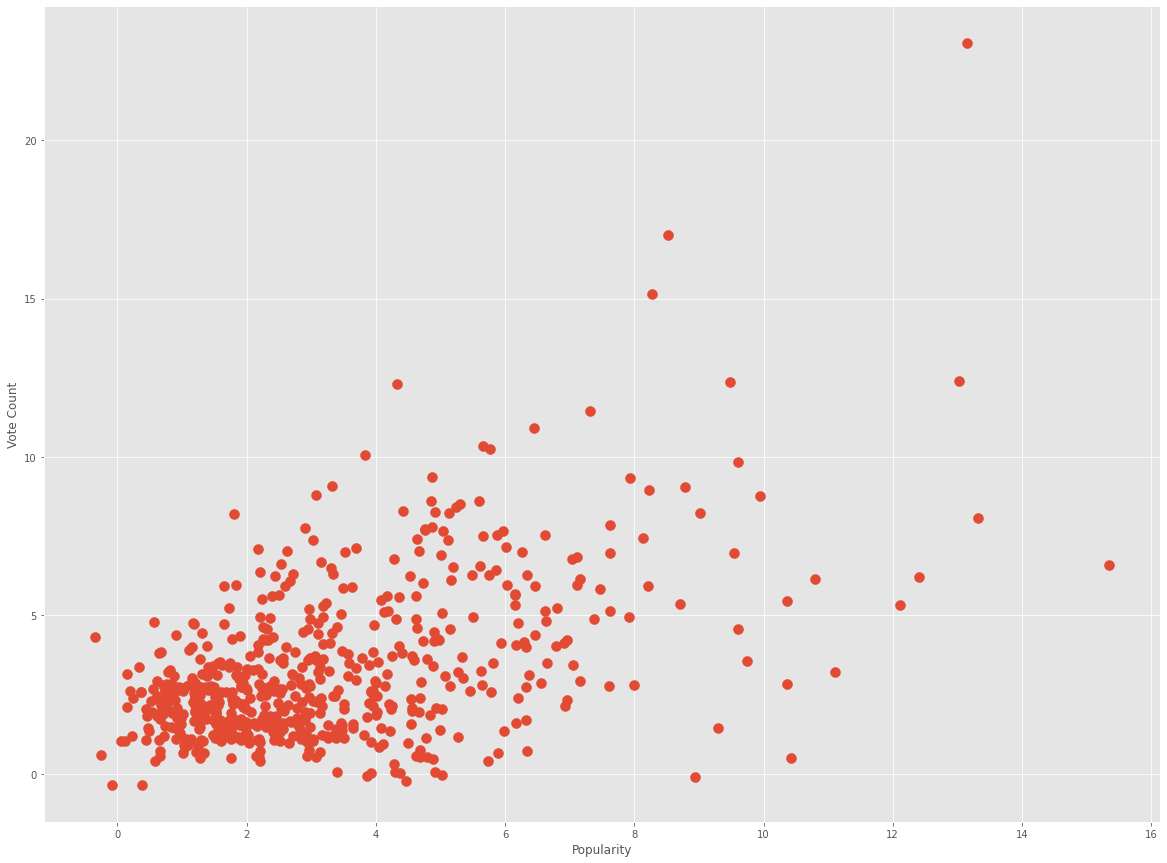

In [31]:
plt.scatter(movies_standardized[:,5][pred_cluster==1],movies_standardized[:,2][pred_cluster==1],s=100)
plt.xlabel('Popularity')
plt.ylabel('Vote Count')

In [32]:
len(pred_cluster[pred_cluster==1])

597

Text(0, 0.5, 'Vote Count')

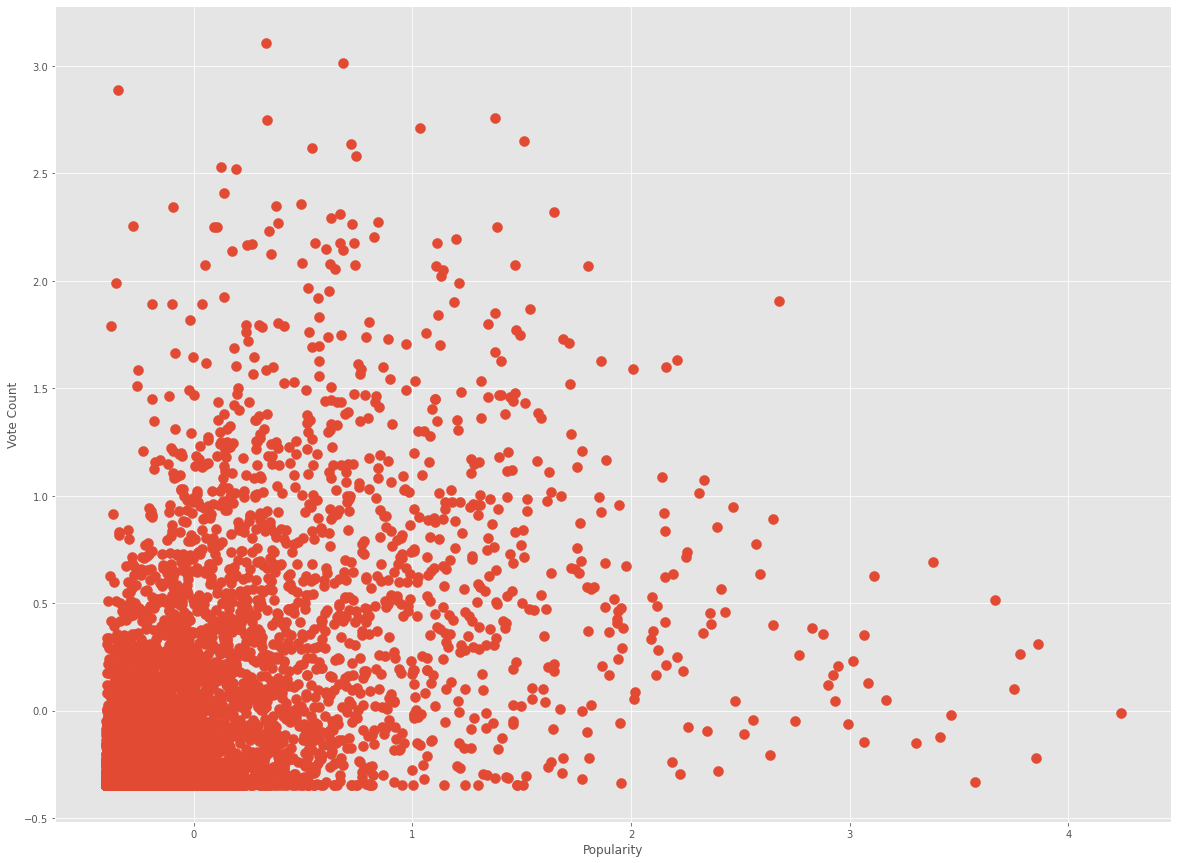

In [33]:
plt.scatter(movies_standardized[:,5][pred_cluster==0],movies_standardized[:,2][pred_cluster==0],s=100)
plt.xlabel('Popularity')
plt.ylabel('Vote Count')

In [34]:
len(pred_cluster[pred_cluster==0])

11581

## Q11 - 12

In [124]:
eps = [ 10.0, 30]
min_samples = [4,8]
distance_metric = ['euclidean','manhattan']
X = copy.deepcopy(movies_standardized)

dbscan_basket = []
best_param, best_score, best_labels,exe_time = None, -1., [],[]

In [125]:
%%time
for e in eps:
    for ms in min_samples:
        for dm in distance_metric:
            start = time.time()
            dbscan = DBSCAN()
            labels = dbscan.fit(X,e,ms,dm)
            exe_time = time.time()-start
            num_labels = len(set(labels))
            if num_labels < 2: continue
            sil = silhouette_score(X, labels)
            params = {
                'eps': e,
                'min_samples': ms,
                'distance_metric': dm,
                'num_labels': num_labels,
                'silhouette': sil,
                'exe_time': exe_time
            }

            dbscan_basket.append(params)
            if sil > best_score:
                best_param = params
                best_score = sil
                best_labels = labels

currently looking at row 12177Wall time: 2h 36min 57s


In [126]:
my_best_param = best_param
my_best_param

{'eps': 30,
 'min_samples': 4,
 'distance_metric': 'euclidean',
 'num_labels': 2,
 'silhouette': 0.9548776432689497,
 'exe_time': 666.6917610168457}

In [127]:
dbscan_basket.sort(key=lambda x: float(x['silhouette']), reverse=True)
table = {
    'eps':[],
    'min_samples':[],
    'distance_metric':[],
    'num_labels':[],
    'silhouette': [],
    'exe_time': []
}

for k, v in table.items():
    table[k] = [row[k] for row in dbscan_basket]

mydbscan = pd.DataFrame(table)
pd.set_option('display.max_rows', None, 'display.max_columns', None)
mydbscan

,eps,min_samples,distance_metric,num_labels,silhouette,exe_time
0,30.0,4,euclidean,2,0.954878,666.691761
1,30.0,8,euclidean,2,0.954878,661.399310
2,30.0,4,manhattan,4,0.889279,983.077908
3,30.0,8,manhattan,4,0.889279,992.203483
4,10.0,4,euclidean,8,0.687027,1460.562800
5,10.0,8,euclidean,8,0.687027,1461.724654
6,10.0,4,manhattan,20,0.513162,2184.055283
7,10.0,8,manhattan,18,0.513136,982.810466


## 13. Interpret the clusters based on the features used for clustering. For example, how is the cluster size related to the features (revenue, vote_count, etc.)?

The number of cluster in this dataset is highly dependent on the 4 data cluster lie on the correlated line between vote_count-revenue, budget-revenue, vote_count-budget and vote_count-popularity as shown in 

In [34]:
movies.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count'],
      dtype='object')

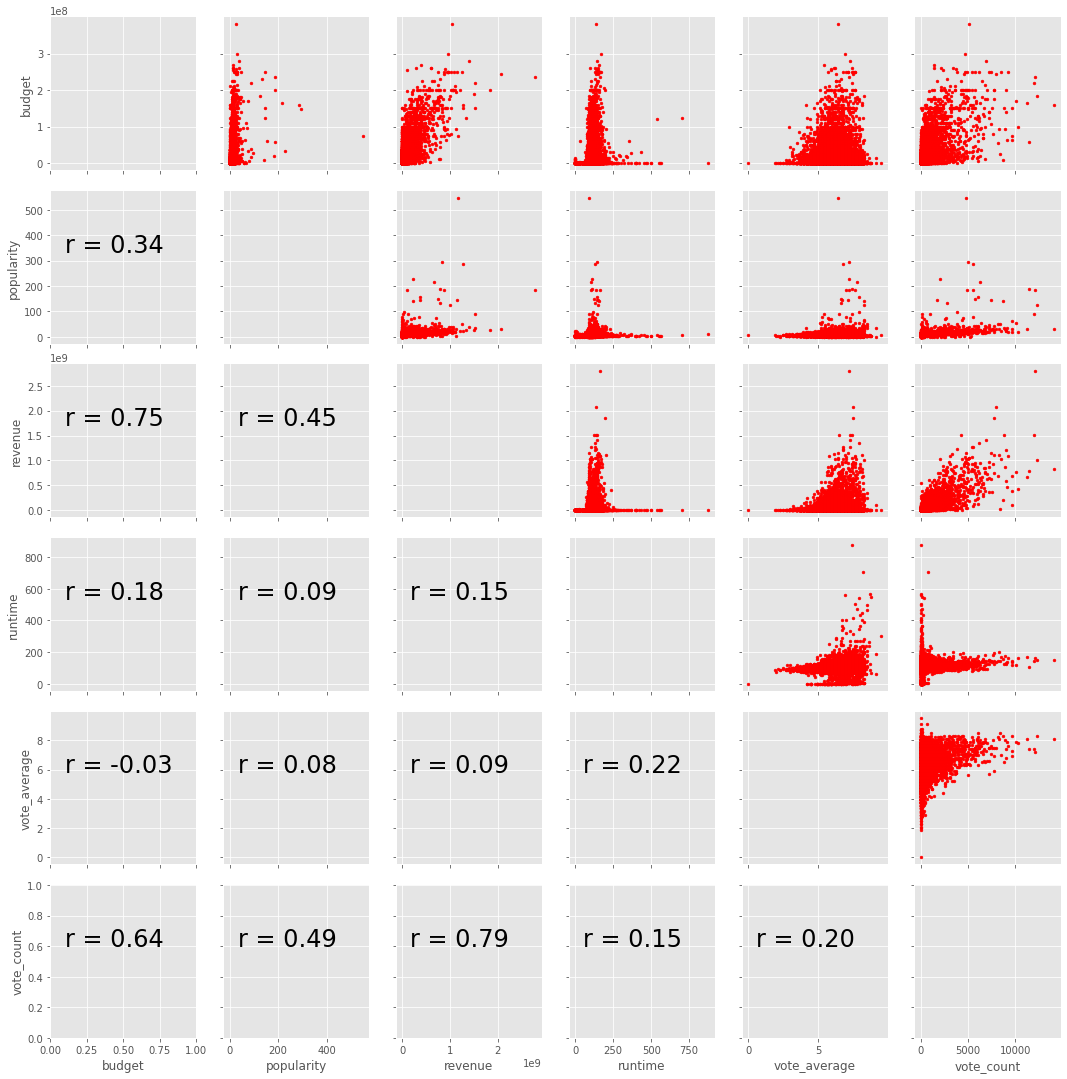

In [35]:
#Generate pair plot
import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
#     print('r', r)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(movies.astype(float))

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=8, color = 'red')

# Correlation coefficients on the lower triangle
g.map_lower(corrfunc)

## 14. Use sklearn’s DBSCAN model to find optimal number of clusters.

In [128]:
import copy
X = copy.deepcopy(movies_standardized)

### Find Optimal Params

In [129]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [130]:

dbscan = DBSCAN(eps=0.1, min_samples=4, metric='euclidean')
pred = dbscan.fit_predict(X)
# Sanity check: The labels of all the instances are now available in the labels_ instance variable.
np.unique(dbscan.labels_)


array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [131]:
#Sanity check
silhouette_score(X, dbscan.labels_)

-0.47437783299860686

In [132]:
eps = [0.1, 1.0, 2.0, 3.5, 5.0, 10.0]
min_samples = [4, 9, 15, 30, 50]
distance_metric = ['euclidean', 'manhattan']

dbscan_basket = []
best_param, best_score, best_labels, exe_time = None, -1., [],[]

In [133]:
for e in eps:
    for ms in min_samples:
        for dm in distance_metric:
            start = time.time()
            dbscan = DBSCAN(eps=e, min_samples=ms, metric=dm)
            dbscan.fit(X)
            exe_time = (time.time() - start)
            num_labels = np.unique(dbscan.labels_).shape[0]
            if num_labels < 2: continue
            sil = silhouette_score(X, dbscan.labels_)
            params = {
                'eps': e,
                'min_samples': ms,
                'distance_metric': dm,
                'num_labels': num_labels,
                'silhouette': sil,
                'exe_time': exe_time
             }

            dbscan_basket.append(params)
            if sil > best_score:
                best_param = params
                best_score = sil
                best_labels = labels

In [134]:
#sanity check
sk_best_param = best_param
sk_best_param

{'eps': 10.0,
 'min_samples': 4,
 'distance_metric': 'euclidean',
 'num_labels': 2,
 'silhouette': 0.9428480074887184,
 'exe_time': 3.362020969390869}

In [135]:
dbscan_basket.sort(key=lambda x: float(x['silhouette']), reverse=True)
table = {
    'eps':[],
    'min_samples':[],
    'distance_metric':[],
    'num_labels':[],
    'silhouette': [],
    'exe_time':[]
}

for k, v in table.items():
    table[k] = [row[k] for row in dbscan_basket]

skdbscan = pd.DataFrame(table)
pd.set_option('display.max_rows', None, 'display.max_columns', None)
skdbscan

,eps,min_samples,distance_metric,num_labels,silhouette,exe_time
0,10.0,4,euclidean,2,0.942848,3.362021
1,10.0,9,euclidean,2,0.942848,3.324176
2,10.0,15,euclidean,2,0.928442,3.329762
3,10.0,30,euclidean,2,0.915008,3.411635
4,10.0,50,euclidean,2,0.915008,3.439874
5,10.0,9,manhattan,2,0.895011,3.427945
6,10.0,15,manhattan,2,0.895011,3.436018
7,10.0,30,manhattan,2,0.893464,3.578354
8,5.0,9,euclidean,2,0.892338,6.262290
9,10.0,50,manhattan,2,0.892124,3.358083


### Finding optimal eps value using Knee method

[ 0.          0.          0.         ...  7.34079986 14.48450177
 26.35515064]


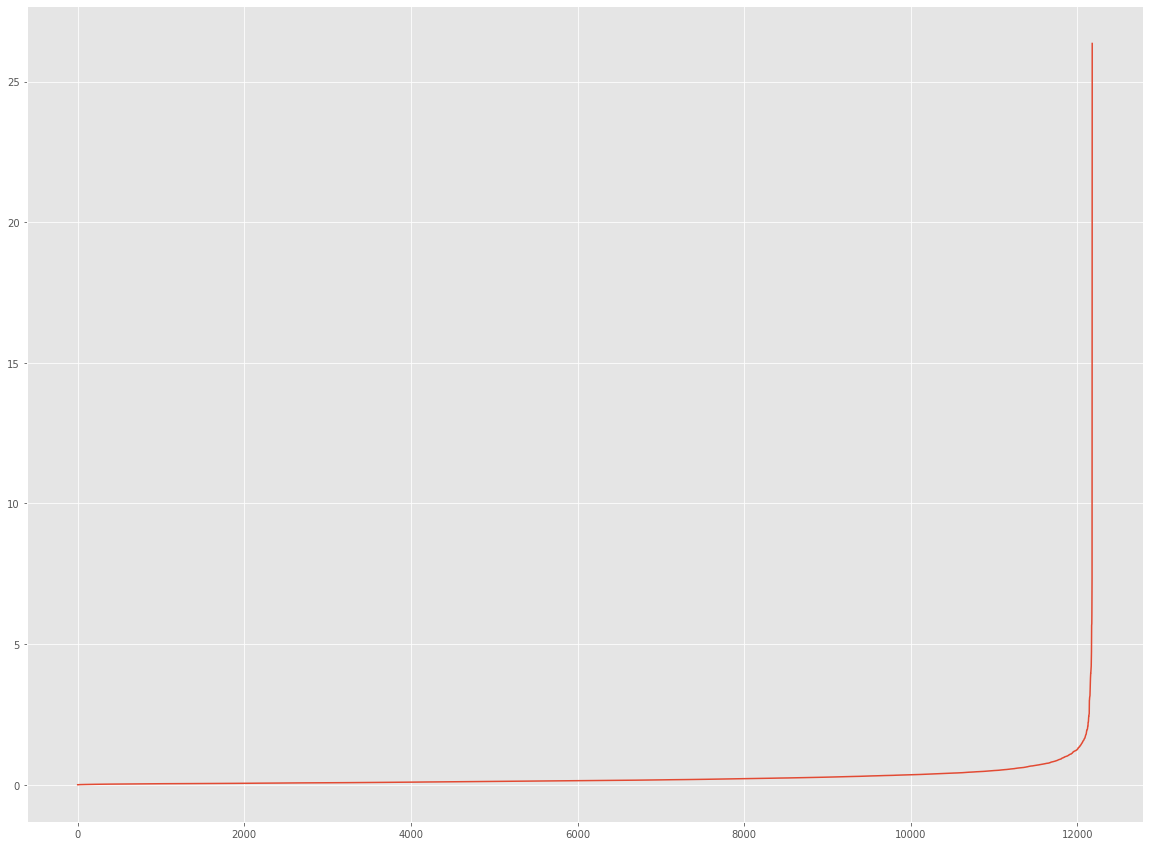

In [136]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=5)
nearest_neighbors.fit(X)
distances, indices = nearest_neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)[:, 1]
print(distances)
plt.plot(distances)
plt.show()

## Q15-17
#### Also refer to the report 

### 15.Compare your solution with sklearn’s DBSCAN model
#### (1) Report the eps and min_samples values,  
#### (2) number of clusters and
#### (3) algorithm running times for both models.

In [137]:
# all_dbscan = pd.DataFrame({'idx':[1,2], 'dfs':[pd.DataFrame(mydbscan), pd.DataFrame(skdbscan)]})
display_side_by_side(mydbscan,skdbscan)

,eps,min_samples,distance_metric,num_labels,silhouette,exe_time
0,30.0,4,euclidean,2,0.954878,666.691761
1,30.0,8,euclidean,2,0.954878,661.399310
2,30.0,4,manhattan,4,0.889279,983.077908
3,30.0,8,manhattan,4,0.889279,992.203483
4,10.0,4,euclidean,8,0.687027,1460.562800
5,10.0,8,euclidean,8,0.687027,1461.724654
6,10.0,4,manhattan,20,0.513162,2184.055283
7,10.0,8,manhattan,18,0.513136,982.810466
,eps,min_samples,distance_metric,num_labels,silhouette,exe_time
0,10.0,4,euclidean,2,0.942848,3.362021


In [143]:
my_best_param

{'eps': 30,
 'min_samples': 4,
 'distance_metric': 'euclidean',
 'num_labels': 2,
 'silhouette': 0.9548776432689497,
 'exe_time': 666.6917610168457}

In [144]:
sk_best_param

{'eps': 10.0,
 'min_samples': 4,
 'distance_metric': 'euclidean',
 'num_labels': 2,
 'silhouette': 0.9428480074887184,
 'exe_time': 3.362020969390869}

### 17. Perform clustering using the efficient implementation of the DBSCAN on Part B dataset.  Compare the algorithm running times for the brute-force and the efficient implementation. Explain the variation in the running times.

In [145]:
%%time
# Optimised DBSCAN with best params
opt_dbscan = opt_DBSCAN()
opt_label = opt_dbscan.fit(X, 30.0, 4 )

currently looking at row 12177Wall time: 9min 54s


# Part C: Outlier Detection


In [5]:
sports = pd.read_csv('Assignment3_Dataset/NHL-2003-2004.csv')

In [6]:
sports.columns

Index(['Player', 'Season', 'Team', 'S/C', 'Pos', 'GP', 'G', 'A', 'P', '+/-',
       'PIM', 'P/GP', 'EVG', 'EVP', 'PPG', 'PPP', 'SHG', 'SHP', 'GWG', 'S',
       'S%', 'TOI/GP', 'FOW%'],
      dtype='object')

In [7]:
sports.head()

,Player,Season,Team,S/C,Pos,GP,G,A,P,+/-,...,EVP,PPG,PPP,SHG,SHP,GWG,S,S%,TOI/GP,FOW%
0,Martin St. Louis,20032004,TBL,L,R,82,38,56,94,35,...,53,8,30,8,11,7,212,17.9,20:35,33.3
1,Ilya Kovalchuk,20032004,ATL,R,L,81,41,46,87,-10,...,52,16,33,1,2,6,341,12,23:06,32.1
2,Joe Sakic,20032004,COL,L,C,81,33,54,87,11,...,49,13,37,1,1,3,253,13,20:16,52.6
3,Markus Naslund,20032004,VAN,L,L,78,35,49,84,24,...,58,5,26,0,0,6,296,11.8,19:23,35.7
4,Marian Hossa,20032004,OTT,L,R,81,36,46,82,4,...,42,14,39,1,1,5,233,15.4,18:37,40


## 1. Display the dimension of data (no. of rows and columns)

In [8]:
sports.shape

(916, 23)

## 2.The shooting percentage (S%) column might have rows with non-numeric values such as "--". Replace those values by 0.0. You may use DataFrame’s “replace” method.

In [9]:
sports1 = sports[['GP', 'G', 'S%']].replace('--', 0.0).astype(float)
sports2 = sports[['P', '+/-', 'PIM']].replace('--', 0.0).astype(float)
sports1.replace('')
sports1.head()

,GP,G,S%
0,82.0,38.0,17.9
1,81.0,41.0,12.0
2,81.0,33.0,13.0
3,78.0,35.0,11.8
4,81.0,36.0,15.4


## 3. Create data matrix from the DataFrame object. Note that we don’t have the data labels. Create two data matrices (X1 and X2) by using feature set 1 and feature set 2, respectively. Thus, X1 and X2 should have 3 columnsindependently

In [10]:
X1, X2 = sports1.values, sports2.values

In [11]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

## 4. Local Outlier Factor: You will useScikit-Learn’s Local Outlier Factor modelfor this task. Findan optimal value for𝑘(number of nearest neighbors) based on the technique described in the notebook on Local Outlier Factor (https://github.com/rhasanbd/Local-Outlier-Factor-Effective-Technique-for-Ranking-Outliers). Briefly, vary the𝑘between a minimum and a maximum value, and compute LOF values for each data point in that range. Then, choose the max LOF value for each data point from that range.


$$
k_{min} = 40 \\
k_{max} = 55 
$$

Optimal k range on X1 dataset = **[43, 44, 45, 46, 47, 48, 49, 50, 51]**

According to heuristic for selecting the range for k, min k is selected by counting minimal cluster size which consist of similar behaving point. Max k is selected by considering maximum number of objects that we want to be outliers if clustered together.

In general, LOF > 1 is used to identify outliers but since  the X1 dataset is sparse, varying density, with many local fluctuation specific to that local cluster, we conclude that datapoint with LOF value > 3. would consider to be an outlier. After filtering out all the LOF values of all datapoint based on the anomaly LOF values, we notice that when k is less than 43 or greater than 51, all datapoint have similar LOG values. when k is in between 43 and 51, the distance points (738th, 742th, 745th) in X1 have much small LOF value. Thus, LOF algorithm successfully detected 3 outliers for k in between 43 and 51.

 
Optimal k range on X2 dataset = **[51, 52, 53, 54, 55]**

Similarly, the same procedure is applied to find optimal k value on X2 dataset. when k is in between 51 and 55, LOF is varied between 2.5 and 3.0. Since the dataset is tight, clean and uniform, the LOF value of around 2.5 were picked as a threshold to determin optimal k.

In [12]:
def compute_negative_lof_mat(X, k_list):
    negative_lof_matrix = np.ones((X.shape[0], len(k_list))) * 99999

    for i in range(len(k_list)):
        lof = LocalOutlierFactor(n_neighbors=k_list[i], algorithm='auto', contamination='auto', n_jobs=-1)
        lof.fit(X)

        # store the negative LOF values in the matrix
        for j in range(len(lof.negative_outlier_factor_)):
            negative_lof_matrix[j, i] = lof.negative_outlier_factor_[j]
    return negative_lof_matrix

def visualize_lof_mat(negative_lof_matrix, k_list):
    print("Negative LOF Matrix: from k = %d to k = %d" % (k_list[0], k_list[len(k_list)-1]))

    datapoint_ids = np.arange(0, negative_lof_matrix.shape[0])

    column_names = [_ for _ in k_list]
    row_names = [_ for _ in datapoint_ids]
    lof_df = pd.DataFrame(np.around(negative_lof_matrix,2), index=row_names, columns=column_names)
    return lof_df



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_scatter3d_abnomaly(_df, anomaly_index, columns=[]):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(_df[columns[0]], _df[columns[1]], _df[columns[2]], facecolors='yellow', alpha=.30, s=100)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_zlabel(columns[2])

    ax.scatter(_df.iloc[anomaly_index][columns[0]],
               _df.iloc[anomaly_index][columns[1]],
               _df.iloc[anomaly_index][columns[2]],
               color="black", alpha=.8)

### For X1

In [143]:
k_min, k_max = 40, 55
k_list = np.arange(k_min, k_max+1)

X1_negative_lof_matrix = compute_negative_lof_mat(X1, k_list)

In [144]:
visualize_lof_mat(X1_negative_lof_matrix, k_list)

Negative LOF Matrix: from k = 40 to k = 55


,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,-1.57,-1.55,-1.57,-1.59,-1.59,-1.61,-1.62,-1.63,-1.64,-1.64,-1.65,-1.65,-1.65,-1.66,-1.66,-1.67
1,-1.75,-1.74,-1.76,-1.77,-1.78,-1.80,-1.81,-1.81,-1.80,-1.81,-1.81,-1.82,-1.83,-1.83,-1.84,-1.84
2,-1.28,-1.29,-1.30,-1.30,-1.31,-1.32,-1.32,-1.32,-1.32,-1.32,-1.32,-1.32,-1.32,-1.32,-1.33,-1.33
3,-1.40,-1.38,-1.38,-1.38,-1.38,-1.39,-1.40,-1.41,-1.41,-1.42,-1.42,-1.42,-1.42,-1.43,-1.43,-1.44
4,-1.45,-1.45,-1.44,-1.45,-1.46,-1.45,-1.46,-1.47,-1.46,-1.47,-1.47,-1.47,-1.47,-1.48,-1.48,-1.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
912,-1.14,-1.14,-1.15,-1.15,-1.17,-1.20,-1.19,-1.19,-1.19,-1.29,-1.29,-1.29,-1.10,-1.10,-1.10,-1.10
913,-1.04,-1.04,-1.04,-1.05,-1.05,-1.10,-1.11,-1.11,-1.12,-1.11,-1.12,-1.13,-1.13,-1.13,-1.14,-1.14
914,-1.06,-1.06,-1.06,-1.06,-1.06,-1.05,-1.06,-1.06,-1.05,-1.05,-1.05,-1.05,-1.05,-1.05,-1.05,-1.05


In [145]:
# find min lof score for each k among datapoints
X1_negative_lof_matrix.min(axis=0)

array([-6.93336803, -7.01772256, -7.09824351, -7.17649895, -7.26147869,
       -6.66904146, -6.69846864, -6.72509301, -6.75986297, -6.78968575,
       -6.82661764, -6.87030942, -6.44690432, -6.490548  , -6.44466682,
       -6.44441655])

In [181]:
#select a reasonable threshold (-6.0) to mask out outliers datapoint
X1_LOF_THRESHOLD = -6.
x1_mask = X1_negative_lof_matrix * (X1_negative_lof_matrix < X1_LOF_THRESHOLD)

In [182]:
#mask out those outlier ids
X1_outlier_ids = np.where(x1_mask.sum(axis=1) != 0.)[0]
X1_outlier_ids

array([738, 742, 745])

In [183]:
# determine the range 
optimal_k_range = np.where((X1_negative_lof_matrix[X1_outlier_ids] < X1_LOF_THRESHOLD).sum(axis=0) >= 3)[0] + k_min
optimal_k_range

array([43, 44, 45, 46, 47, 48, 49, 50, 51])

### For X2

In [149]:
k_min, k_max = 40, 55
k_list = np.arange(k_min, k_max+1)

X2_negative_lof_matrix = compute_negative_lof_mat(X2, k_list)
visualize_lof_mat(X2_negative_lof_matrix, k_list)

Negative LOF Matrix: from k = 40 to k = 55


,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,-1.81,-1.82,-1.83,-1.84,-1.85,-1.85,-1.87,-1.87,-1.87,-1.87,-1.86,-1.87,-1.87,-1.88,-1.88,-1.88
1,-1.42,-1.42,-1.42,-1.42,-1.43,-1.42,-1.43,-1.43,-1.43,-1.44,-1.45,-1.45,-1.44,-1.44,-1.44,-1.44
2,-1.34,-1.35,-1.34,-1.34,-1.35,-1.35,-1.36,-1.36,-1.36,-1.36,-1.36,-1.37,-1.36,-1.36,-1.37,-1.37
3,-1.35,-1.35,-1.36,-1.36,-1.35,-1.34,-1.35,-1.34,-1.34,-1.34,-1.35,-1.35,-1.35,-1.36,-1.36,-1.36
4,-1.26,-1.26,-1.27,-1.27,-1.27,-1.28,-1.27,-1.28,-1.27,-1.28,-1.28,-1.28,-1.28,-1.28,-1.29,-1.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,-1.38,-1.39,-1.41,-1.42,-1.43,-1.43,-1.41,-1.42,-1.41,-1.24,-1.23,-1.25,-1.25,-1.19,-1.19,-1.19
912,-1.05,-1.05,-1.06,-1.08,-1.08,-1.10,-1.09,-1.08,-1.08,-1.13,-1.13,-1.14,-1.14,-1.07,-1.08,-1.08
913,-1.41,-1.40,-1.40,-1.40,-1.41,-1.41,-1.41,-1.43,-1.43,-1.33,-1.33,-1.33,-1.33,-1.28,-1.30,-1.29
914,-1.15,-1.15,-1.15,-1.15,-1.15,-1.15,-1.15,-1.15,-1.14,-1.15,-1.15,-1.15,-1.15,-1.14,-1.14,-1.15


In [150]:
# find min lof score for each k among datapoints
X2_negative_lof_matrix.min(axis=0)

array([-2.88397674, -2.95251592, -3.01604714, -2.96088978, -2.94369769,
       -2.94329705, -2.91718783, -2.88586352, -2.89807297, -2.92106714,
       -2.94050856, -2.94414943, -2.95950934, -2.97749379, -2.99937377,
       -3.01154567])

In [220]:
X2_LOG_THRESHOLD = -2.77

In [221]:
#select a reasonable threshold to mask out outliers datapoint
x2_mask = X2_negative_lof_matrix * (X2_negative_lof_matrix < X2_LOG_THRESHOLD)

#mask out those outlier ids
X2_outlier_ids = np.where(x2_mask.sum(axis=1) != 0.)[0]
X2_outlier_ids

array([243, 248, 589, 598, 746])

In [153]:
X2_negative_lof_matrix[X2_outlier_ids]

array([[-2.65531525, -2.66431256, -2.64583344, -2.66103072, -2.65114144,
        -2.6708332 , -2.6886345 , -2.70233235, -2.72781641, -2.74856656,
        -2.74732292, -2.7575685 , -2.77216623, -2.78941269, -2.81050104,
        -2.82248202],
       [-2.879405  , -2.86686766, -2.86437067, -2.84316302, -2.83121058,
        -2.8486785 , -2.8712748 , -2.88586352, -2.89807297, -2.92106714,
        -2.94050856, -2.94414943, -2.95950934, -2.97749379, -2.99937377,
        -3.01154567],
       [-2.88397674, -2.95251592, -3.01604714, -2.96088978, -2.94369769,
        -2.94329705, -2.91718783, -2.88527633, -2.86088627, -2.67804646,
        -2.68041684, -2.66845278, -2.71544848, -2.73933319, -2.7748945 ,
        -2.80512453],
       [-2.575616  , -2.59150268, -2.59619629, -2.61707787, -2.60756445,
        -2.63207387, -2.6622448 , -2.67866878, -2.70559136, -2.72210462,
        -2.73942763, -2.75668773, -2.75586136, -2.77505494, -2.76133874,
        -2.74475611],
       [-2.43397054, -2.41719034, -2

In [154]:
X2_negative_lof_matrix[X2_outlier_ids] < X2_LOG_THRESHOLD

array([[False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False,  True,  True]])

In [155]:
from scipy import stats 
pd.DataFrame(X2_negative_lof_matrix).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000
mean,-1.138418,-1.140410,-1.141908,-1.143597,-1.145546,-1.147235,-1.148101,-1.149048,-1.150441,-1.141531,-1.143087,-1.144546,-1.145176,-1.142771,-1.144352,-1.145625
std,0.219815,0.222675,0.224290,0.226086,0.227701,0.230546,0.231163,0.232387,0.234033,0.223866,0.225991,0.227257,0.228586,0.226894,0.228759,0.230556
min,-2.883977,-2.952516,-3.016047,-2.960890,-2.943698,-2.943297,-2.917188,-2.885864,-2.898073,-2.921067,-2.940509,-2.944149,-2.959509,-2.977494,-2.999374,-3.011546
25%,-1.186579,-1.192090,-1.197190,-1.197247,-1.202698,-1.203299,-1.203061,-1.206377,-1.208515,-1.195407,-1.198396,-1.199707,-1.199679,-1.193064,-1.191796,-1.193576
50%,-1.057064,-1.055989,-1.056820,-1.057896,-1.057630,-1.058470,-1.058581,-1.061266,-1.061716,-1.062578,-1.063725,-1.065930,-1.067179,-1.065132,-1.066256,-1.067417
75%,-1.011438,-1.011128,-1.011979,-1.011932,-1.013354,-1.013705,-1.011742,-1.011261,-1.012065,-1.012990,-1.013146,-1.012980,-1.013374,-1.013247,-1.013413,-1.013470
max,-0.960441,-0.959886,-0.959038,-0.955982,-0.954336,-0.953443,-0.962089,-0.966352,-0.970394,-0.970450,-0.973014,-0.972513,-0.971985,-0.975893,-0.974723,-0.973996


## 5 + 6. Using max LOF values for each data pointidentify the first 3~5 outliers both for feature set 1 and feature set 2. You may vary model parametersto optimize your results,if necessary. Justify result

### Feature set #1

As shown in experiment below, datapoint 712th, 738th, 742th, 743th and 745th are detected by LOF algorithm as anomaly with three top worth highlighting anomaly 712th, 738th, and 742th. The same characteristic that.listed anomaly has in common is extremely low gameplayed, goals scored values and high shooting percentage. Intuitively, this is expected as in most hockey league, the number of gameplayed should be proportional to shoot percentage indicate that the play play well and are given many opportunity to make a strike. The 3 anomaly datapoint went against with gameplayed-shooting percentage proportionality logic thus, algorithm detected it in the low density area.

Datapoint #743, #745 is also classified as anomaly due to its extremely low gameplayed and goal score values. In real life, this incident rarely happen because professional league often optimize there budget and hire well played hockey player to play often through out the league. These 2 incident indicate that there number of gameplayed, shooting percentage and goal scored is same. This can be interpret as luck. 

In [27]:
sports1.describe()

,GP,G,S%
count,916.000000,916.000000,916.000000
mean,48.378821,6.896288,7.253057
std,28.737165,8.108765,7.568007
min,1.000000,0.000000,0.000000
25%,18.000000,1.000000,1.800000
50%,57.000000,4.000000,6.600000
75%,75.000000,11.000000,10.900000
max,83.000000,41.000000,100.000000


In [28]:
X1_outlier_ids

array([712, 738, 742, 743, 745])

In [29]:
sports1.iloc[X1_outlier_ids]

,GP,G,S%
712,4.0,1.0,50.0
738,3.0,1.0,100.0
742,2.0,1.0,100.0
743,1.0,1.0,25.0
745,4.0,1.0,10.0


#### VIsualize Outliers on Feature Set #1

In [191]:
sports1

eps                       10
min_samples                4
distance_metric    euclidean
num_labels                 2
silhouette          0.942848
Name: 0, dtype: object

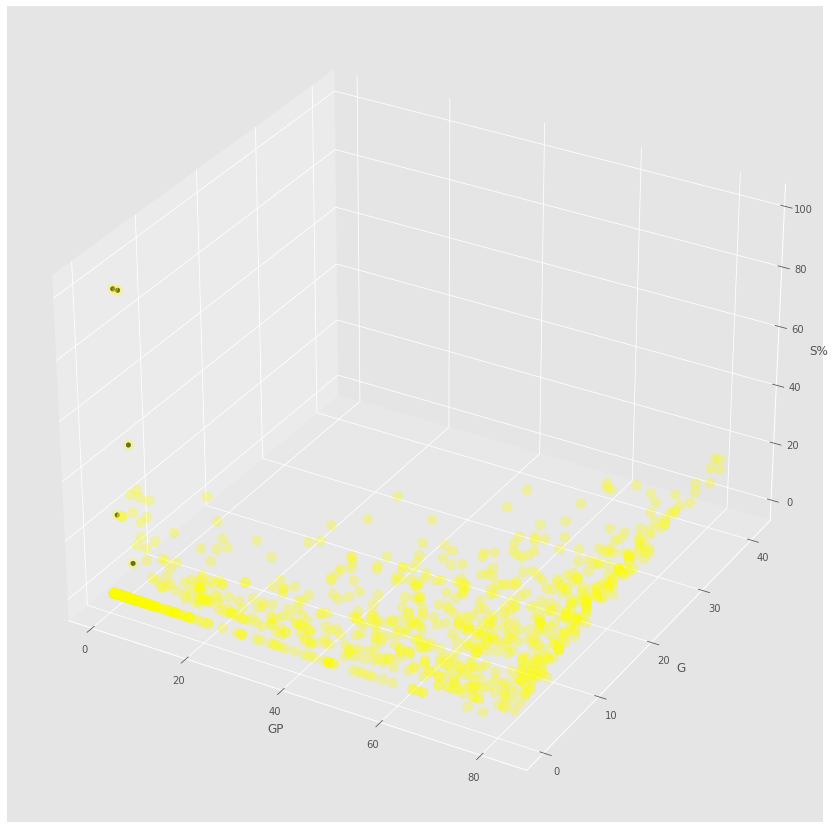

In [156]:
plot_scatter3d_abnomaly(sports1, X1_outlier_ids, ['GP', 'G', 'S%'])

### Feature set #2

The algorithm classified datapoint as anomaly based on 2 category of logic. 

1. moderate point scored, moderate plus-minus statistic, and high penalty-minute values (243th, 248th, and 598)
2. moderate point scored, moderate plus-minus statistic, and low penalty-minute values (589th, 746th)

Intuitively, this is expected as moderated point-scored, moderate plus-minus(game impact) player are well trained and know the rule well so they should be expected to have small number of penalty in a game. Since well played player are often have high number of game played, they are expected to have more conflict thus the number of of penalty should be moderate.


Note: Moderate means near expectation value and within 1 std.


In [157]:
sports2.describe()

,P,+/-,PIM
count,916.000000,916.000000,916.000000
mean,18.579694,-0.284934,38.791485
std,19.256372,9.914974,39.623683
min,0.000000,-46.000000,0.000000
25%,2.750000,-5.250000,10.000000
50%,12.000000,-1.000000,26.000000
75%,29.000000,4.000000,54.250000
max,94.000000,35.000000,261.000000


In [158]:
X2_outlier_ids

array([243, 248, 589, 598, 746])

In [159]:
sports2.iloc[X2_outlier_ids]

,P,+/-,PIM
243,28.0,15.0,250.0
248,28.0,2.0,261.0
589,6.0,5.0,0.0
598,5.0,-8.0,247.0
746,1.0,-9.0,0.0


#### Visualize Outliers on Feature set #2

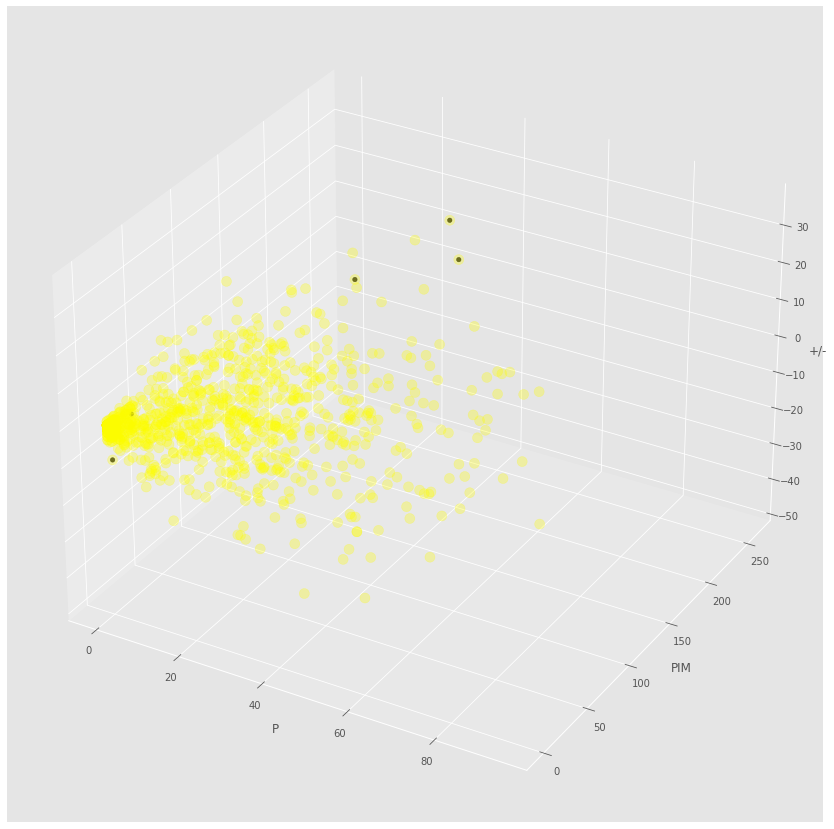

In [222]:
plot_scatter3d_abnomaly(sports2, X2_outlier_ids, ['P', 'PIM', '+/-'])

## 7 + 8. Isolation Forest: Using Scikit-Learn’s Isolation Forestobjectidentify the first 3~5 outliers both for feature set 1 and feature set 2. You may vary model parameters to optimize your results, if necessary. Interpret your results.

In [162]:
from sklearn.ensemble import IsolationForest

In [163]:
sports1_iso = sports1.copy()

In [164]:
%time

#n_estimators: # of tree
iso_forest = IsolationForest(n_estimators=256, max_samples='auto', contamination=0.005,
                    max_features=1.0, bootstrap=False, verbose=1, n_jobs=-1, random_state=42, behaviour="new")

tic = time()
iso_forest.fit(sports1_iso)
toc = time()
toc - tic

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.4s remaining:    2.6s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished


0.532397985458374

In [165]:
sports1_iso['iso_scores'] = iso_forest.decision_function(X1)
sports1_iso['anomaly'] = iso_forest.predict(X1)

In [166]:
anomaly=sports1_iso.loc[sports1_iso['anomaly']==-1]
anomaly_index=list(anomaly.index)
anomaly

,GP,G,S%,iso_scores,anomaly
510,15.0,5.0,31.3,-0.007376,-1
693,4.0,2.0,33.3,-0.001697,-1
712,4.0,1.0,50.0,-0.002249,-1
738,3.0,1.0,100.0,-0.076697,-1
742,2.0,1.0,100.0,-0.078487,-1


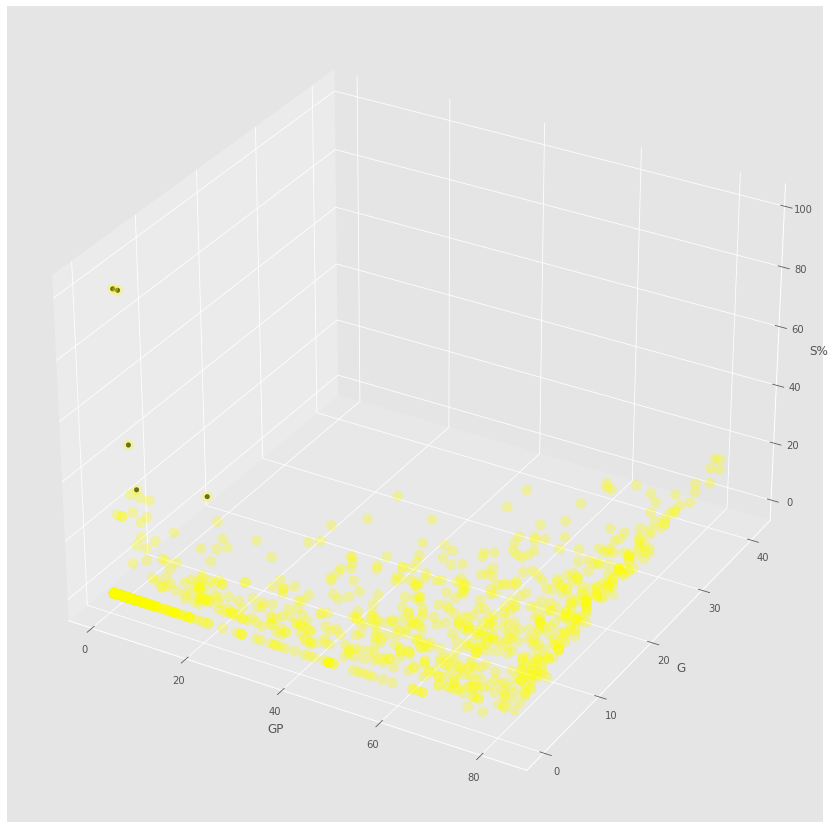

In [168]:
plot_scatter3d_abnomaly(sports1_iso, anomaly_index, ['GP', 'G', 'S%'])

### Feature set #2

In [169]:
sports2_iso = sports2.copy()

iso_forest2 = IsolationForest(n_estimators=256, max_samples='auto', contamination=0.005,
                    max_features=1.0, bootstrap=False, verbose=1, n_jobs=-1, random_state=42, behaviour="new")

tic = time()
iso_forest2.fit(sports2_iso)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.4s remaining:    2.7s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished


IsolationForest(behaviour='new', contamination=0.005, n_estimators=256,
                n_jobs=-1, random_state=42, verbose=1)

In [170]:
sports2_iso['iso_scores'] = iso_forest2.decision_function(X2)
sports2_iso['anomaly'] = iso_forest2.predict(X2)

In [171]:
anomaly2=sports2_iso.loc[sports2_iso['anomaly']==-1]
anomaly2_index=list(anomaly2.index)
anomaly2

,P,+/-,PIM,iso_scores,anomaly
0,94.0,35.0,24.0,-0.054908,-1
40,57.0,-35.0,87.0,-0.001272,-1
132,41.0,33.0,147.0,-0.023050,-1
243,28.0,15.0,250.0,-0.022179,-1
248,28.0,2.0,261.0,-0.011315,-1


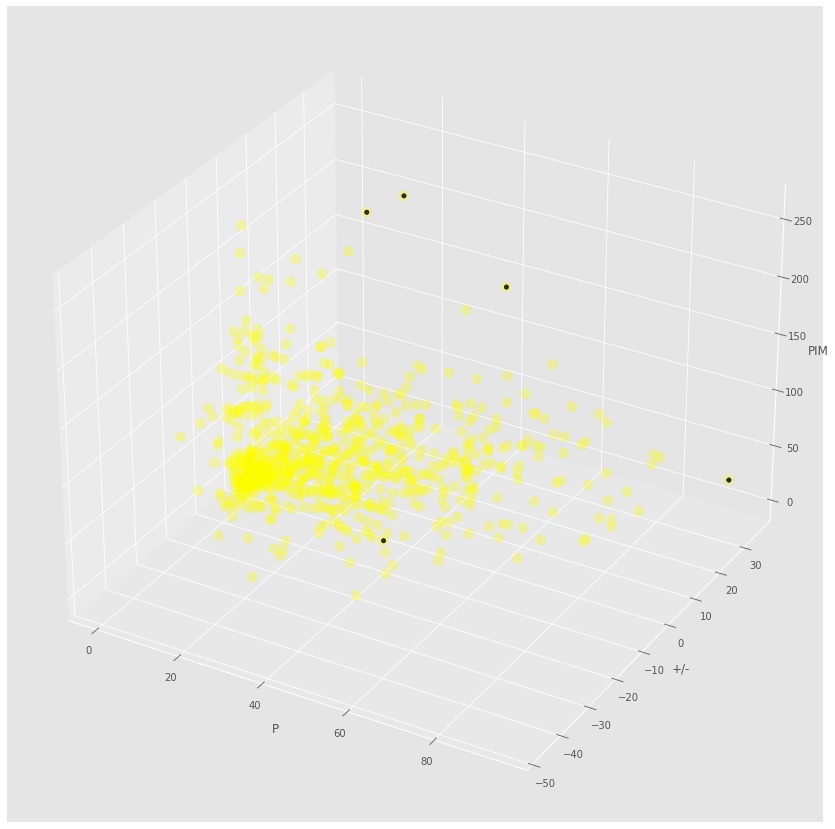

In [172]:
plot_scatter3d_abnomaly(sports2_iso, anomaly2_index, ['P', '+/-', 'PIM'])

## 9. Compare the results obtained from Local Outlier Factor and Isolation Forest.Which technique you think performed better and why?


Visually, isolation forest model is more sensitive to global outlier as shown in picture showing anomaly in feature set #2. anomaly lie in the low density with extreme feature values. Technically speaking, this is expected as the algorithm try to create multiple decision branch base on a common mean values therefore, exceptionally low and high values will be detected and classified in the sparse branch region.

In case of LOF, the algorithm has advantage due to the local aspect of LOF, meaning hthat it only compares the score of anomality of one sample with the score of its neighbors.

Depend on the application, isolation forest can be chosen over LOF where global anomaly is more interested over local


# Perform outlier detection on the same dataset for both feature sets using sklearn’s Gaussian Mixture Model (GMM)object

In [54]:
from sklearn.mixture import GaussianMixture

def find_optimal_k_BIC_AIC(X_mat, neighbors_range = np.arange(1,21)):
    gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X1)
                 for k in neighbors_range]
    bics = [model.bic(X1) for model in gms_per_k]
    aics = [model.aic(X1) for model in gms_per_k]

    # Find the value of "k" that gives minimum BIC
    j = 0
    min_bic = bics[j]
    max_k = 1

    for i in neighbors_range:
        if(bics[j] < min_bic):
            min_bic = bics[j]
            max_k = i
        j +=1
    return max_k


def plot_BIC_AIC_values(bics, aics):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 21), bics, "bo-", label="BIC")
    plt.plot(range(1, 21), aics, "go--", label="AIC")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Information Criterion", fontsize=14)
    plt.legend()
    plt.show()

 ## 10. Find an optimal number of components using Bayesian information criterion (BIC) andAkaike information criterion (AIC) using GMM 
## 11. Using the optimal number of components identify the first 3~5 outliers both for feature set 1 and feature set 2. You may vary model parameters to optimize your results, if necessary. 
## 12. Interpret result

GMM is a Gaussian based model meaning each datapoint is evaluated among other to find its likelihood on belonging to a cluster. Since each datapoint is falled within a smoothed Gaussian distribution, therefore, instance located in low-density region will be considered as anomaly. Visually, datapoints 3, 22, 50, 64, ... 712 lied in the low density region. Datapoint 738th and 742th, who were classified as anomaly by LFO and Isolation Forest, were not detected by GMM as anomaly. This is expected because lots of other datapoint have low GP and G values which balance out the density thus, 738th and 742th were not classified as anomaly. Same argument can be held for feature set #2

### Feature set #1

#### Find Optimal k

In [56]:
%% time 
maxk1 = find_optimal_k_BIC_AIC(X1, neighbors_range=np.arange(1, 21))

In [57]:
maxk1

17

#### GMM: Train using Optimal k

In [58]:
gmm1 = GaussianMixture(n_components=maxk1, n_init=10, random_state=42)
gmm1.fit(X1)

GaussianMixture(n_components=17, n_init=10, random_state=42)

#### Find outliers

In [61]:
densities = gmm1.score_samples(X1) 
density_threshold = np.percentile(densities, 1) #density < threshold is anomaly
abnomaly_gmm_detected_index = np.where(densities < density_threshold)[0]

In [80]:
sports1.iloc[abnomaly_gmm_detected_index]

,GP,G,S%
3,78.0,35.0,11.8
22,75.0,30.0,22.1
50,39.0,18.0,21.2
64,55.0,24.0,15.0
69,45.0,19.0,14.3
87,72.0,28.0,22.6
166,59.0,24.0,22.9
521,57.0,7.0,33.3
687,29.0,2.0,28.6
712,4.0,1.0,50.0


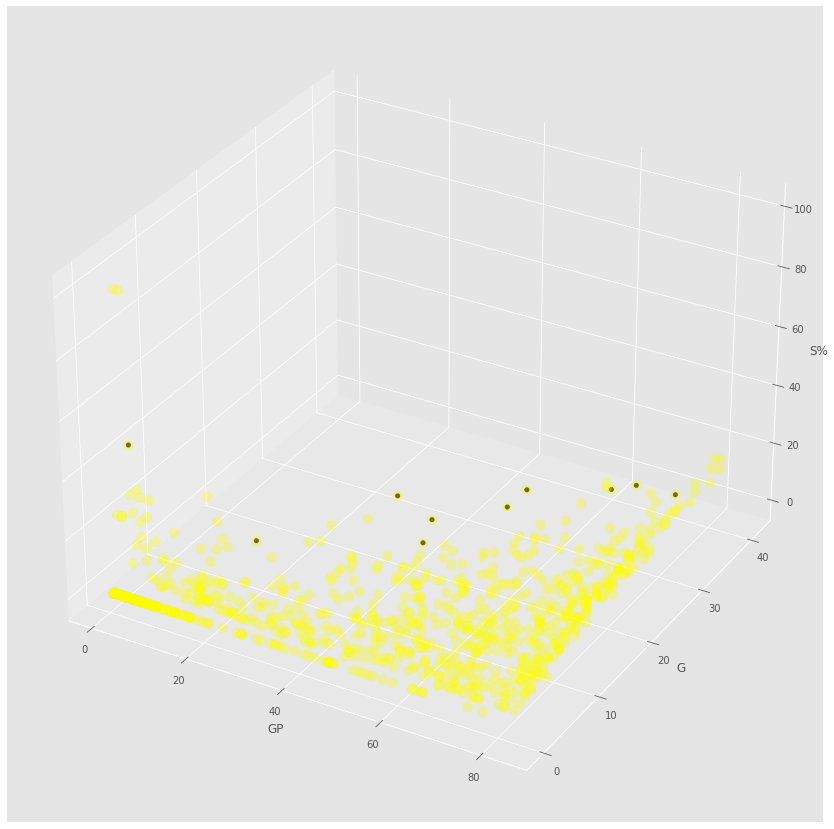

In [78]:
plot_scatter3d_abnomaly(sports1, abnomaly_gmm_detected_index, ['GP', 'G', 'S%'])

### Feature set #2

#### Find optimal K

In [69]:
%%time 
maxk2 = find_optimal_k_BIC_AIC(X2, neighbors_range=np.arange(1, 21))

CPU times: user 57.9 s, sys: 3.72 s, total: 1min 1s
Wall time: 10.4 s


In [70]:
maxk2

17

#### Train using optimal k

In [72]:
gmm2 = GaussianMixture(n_components=maxk2, n_init=10, random_state=42)
gmm2.fit(X2)

GaussianMixture(n_components=17, n_init=10, random_state=42)

#### Find Outliers

In [73]:
densities2 = gmm2.score_samples(X2) 
density_threshold2 = np.percentile(densities2, 1) #density < threshold is abnomaly
abnomaly_gmm_detected_index2 = np.where(densities2 < density_threshold2)[0]

In [81]:
sports2.iloc[abnomaly_gmm_detected_index2]

,P,+/-,PIM
1,87.0,-10.0,63.0
15,73.0,21.0,84.0
24,68.0,-4.0,12.0
34,60.0,21.0,122.0
40,57.0,-35.0,87.0
174,34.0,-46.0,54.0
252,28.0,-13.0,102.0
365,19.0,35.0,45.0
474,11.0,-26.0,18.0
504,10.0,-36.0,127.0


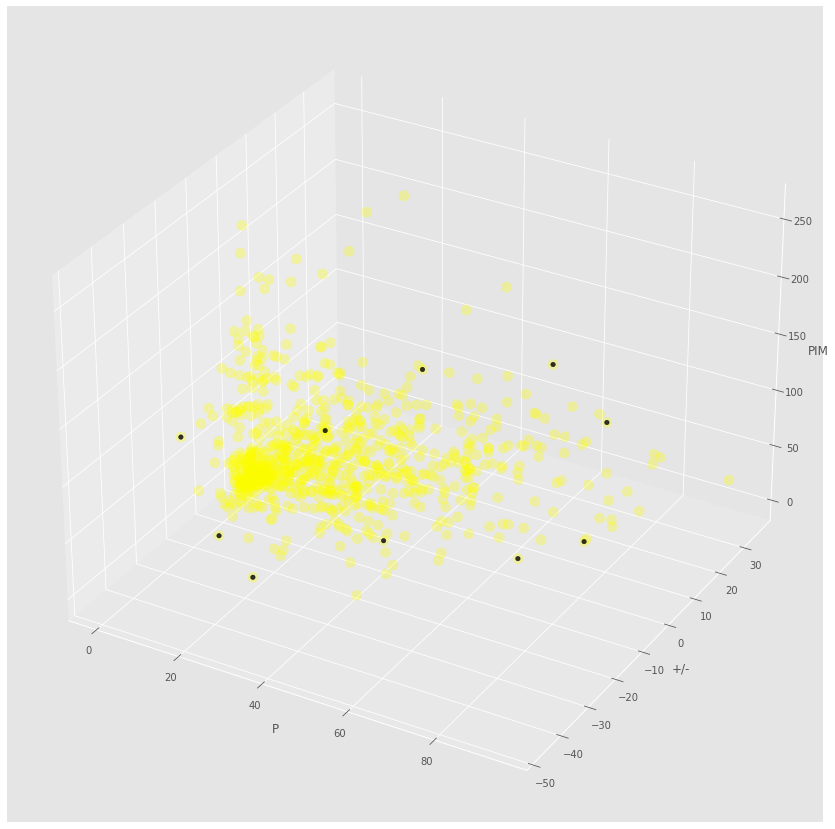

In [79]:
plot_scatter3d_abnomaly(sports2, abnomaly_gmm_detected_index2, ['P', '+/-', 'PIM'])

### 13. Compare GMM based outliers with Local Outlier Factor and Isolation Forest. Which technique you think performed better outlier detection and why?


GMM takes different approach as LOF and Isolation Forest. GMM is a generative model, aiming to learn the probablity distribution governing the dataset, while the latter is an pure outlier detection model, which rather than finding the clusters in dataset, detects outlying points. Since GMM is govern by a probability distribution, datapoint in a low threshold is classifed as anomaly. If dataset have a high dimension then value in one dimension can balance out the other thus, GMM can fail to detect such points. LOF and isolcation forest can be used as alternative.

It is challenging to call 1 model perform better than other as depending on the dataset one can be prefered over other. For application like detecting anomaly player in sport, LOF and isolation forest can be used as those player with exceptionally high and low in a score can possibly be anomaly. Overall, GMM requires significantly longer time to train, excluding the reuiqred time for optimal k selection. 